# Generateive Pre-trained Transformer 2 From Scratch
The purpose of this notebook is to guide through the process of building a Generative Pre-trained Transformer 2 (GPT-2) model from scratch. GPT-2 was a state-of-the-art language generation model developed by OpenAI, which has been trained on a large corpus of text data and can generate coherent and contextually relevant text.

The impact of this model has been significant, as it has demonstrated the ability to generate human-like text and perform well on a variety of natural language processing tasks. In this notebook, we will explore the architecture of the GPT-2 model, train it on a text dataset, and evaluate its performance on a text generation task.

This is the newer Decoder-only version of the Transformer architecture, which is used for language modeling tasks. The Transformer architecture has been widely adopted in the field of natural language processing due to its ability to capture long-range dependencies in text data and its parallelizable nature.

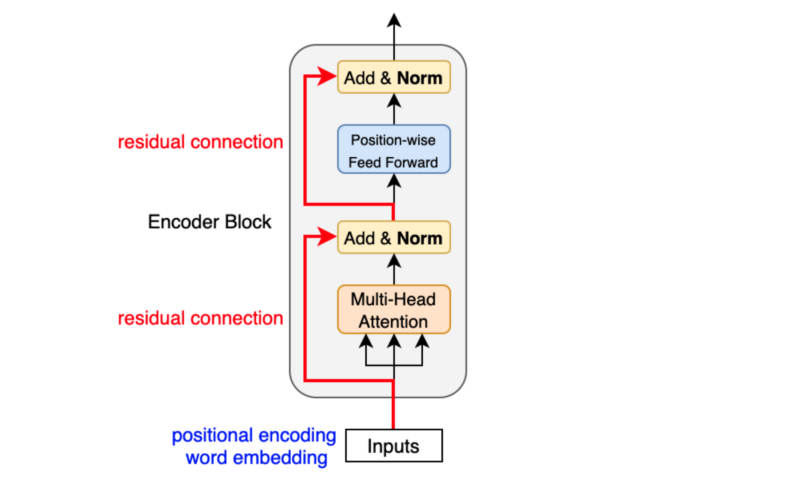

This is the original Transformer architecture, which consists of an encoder and a decoder. The encoder processes the input sequence and generates a sequence of hidden states, while the decoder generates the output sequence based on the encoder's hidden states and the previous output tokens.

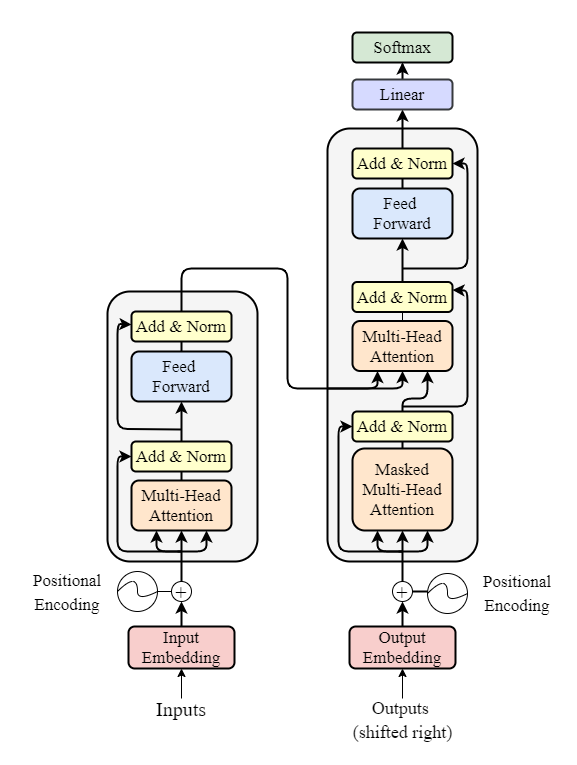

The notebook will cover the following topics:

Overview of the Transformer architecture: Understand the key components of the Transformer architecture, including self-attention mechanisms and feedforward neural networks.

Data preparation: Learn how to prepare and preprocess the text data for training the GPT-2 model.

Training: Train the GPT-2 model using the preprocessed text data and optimize its parameters to minimize a suitable loss function.

Inference: Generate text using the trained GPT-2 model and evaluate its performance on a text generation task.


References:

- [OpenAI GPT-2 Paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
- [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)
- [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)


In [ ]:
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer

# 1. Input Embedding

Can be implemented a PyTorch Embedding layer.
```python
input_embedding = InputEmbedding(512, 10000)
x = torch.rand(1, 100).long()
embedded_input = input_embedding(x)
print(embedded_input.shape)
```

In [ ]:
class InputEmbedding(nn.Module):
    def __init__(self, embed_dim: int, vocab_size: int):
        """
        Initialize the InputEmbedding module.

        Args:
            embed_dim (int): The dimensionality of the input embedding.
            vocab_size (int): The size of the vocabulary.

        """
        super().__init__()
        # Store the dimensionality and vocabulary size
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size

        # Create an embedding layer that maps the vocabulary to a embed_dim-dimensional space
        # The embedding layer should have shape (vocab_size, embed_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
    
    def forward(self, x):
        """
        Perform the forward pass of the InputEmbedding module.

        Args:
            x (tensor): The input tensor.

        Returns:
            tensor: The embedded input tensor after scaling it by the square root of the dimensionality.

        """
        # Embed the input tensor using the embedding layer
        # Shape: (batch_size, seq_len) -> (batch_size, seq_len, embed_dim)
        embedded_input = self.embedding(x)
        # Scale the embedded input tensor by the square root of the dimensionality
        # Shape: (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        scaled_embedded_input = embedded_input * torch.sqrt(torch.tensor(self.embed_dim))
        return scaled_embedded_input

# 2. Positional Encoding

Can be implemented as a layer in PyTorch.

```python
x = torch.rand(1, 100, 512)
positional_encoding = PositionalEncoding()
output = positional_encoding(x)
print(output.shape)
```

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim: int = 512, max_seq_len: int = 100, dropout: float = 0.1):
        """Initialize the PositionalEncoding module."""
        super().__init__()
        self.embed_dim = embed_dim
        self.max_seq_len = max_seq_len
        self.dropout = nn.Dropout(dropout)
        # Precompute the positional encoding matrix
        self.positional_encoding = self._precompute_positional_encoding(max_seq_len, embed_dim)

    def _precompute_positional_encoding(self, max_seq_len, embed_dim):
        """Precompute the positional encoding matrix."""
        with torch.no_grad():
            # Create a positional encoding matrix of shape (max_seq_len, embed_dim)
            positional_encoding = torch.zeros(max_seq_len, embed_dim)
            # Create a tensor 'pos' with values [0, 1, 2, ..., max_seq_len - 1] (max_seq_len, 1)
            position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
            # Compute the positional encoding matrix
            division_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
            positional_encoding[:, 0::2] = torch.sin(position * division_term)
            positional_encoding[:, 1::2] = torch.cos(position * division_term)
            # Shape (max_seq_len, embed_dim) -> (1, max_seq_len, embed_dim)
            positional_encoding = positional_encoding.unsqueeze(0)

        return positional_encoding

    def forward(self, x):
        """Perform the forward pass of the PositionalEncoding module."""
        # Add the positional encoding matrix to the input tensor
        x = x + self.positional_encoding[:, : x.size(1)]
        # Apply dropout to the input tensor
        x = self.dropout(x)
        return x

# 3. Layer Normalization

In [ ]:
class LayerNormalization(nn.Module):
    def __init__(self, embed_dim: int, eps: float = 1e-6):
        """Initialize the LayerNormalization module."""
        super().__init__()
        self.eps = eps
        # Create two learnable parameters to scale and shift the normalized input
        self.gain = nn.Parameter(torch.Tensor(embed_dim).uniform_())  # Initialize with values sampled from a uniform distribution
        self.bias = nn.Parameter(torch.Tensor(embed_dim).normal_())    # Initialize with values sampled from a normal distribution


    def forward(self, x):
        """Perform the forward pass of the LayerNormalization module."""
        # Compute the mean and standard deviation of the input tensor
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # Zero center by subtracting the mean from the input tensor
        # Normalize scale by dividing by the standard deviation and add epsilon for numerical stability
        # Scale and shift the normalized input using the learnable parameters
        return (x - mean) / (std + self.eps) * self.gain + self.bias

# 4. Feed Forward Block

In [ ]:
class FeedForwardBlock(nn.Module):
    def __init__(self, embed_dim: int, intermediate_size: int, dropout: float = 0.1):
        """Initialize the FeedForwardBlock module.
        embed_dim is the hidden size of the transformer model functions as input and output size of the FeedForwardBlock
        intermediate_size is the hidden size of the intermediate layer in the FeedForwardBlock
        dropout is the dropout probability
        """
        super().__init__()
        # embed_dim is the dimensionality of the input and output of the FeedForwardBlock
        # intermediate_size is the dimensionality of the intermediate layer in the FeedForwardBlock
        self.fc1 = nn.Linear(embed_dim, intermediate_size) # W1 and B1 in the formula
        self.fc2 = nn.Linear(intermediate_size, embed_dim) # W2 and B2 in the formula
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """Perform the forward pass of the FeedForwardBlock module."""
        # (Batch, Seq_len, embed_dim) -> (Batch, Seq_len, intermediate_size) -> (Batch, Seq_len, embed_dim)
        x_intermediate = self.dropout(F.relu(self.fc1(x)))
        x_output = self.fc2(x_intermediate)
        return x_output

# 5. Multi-Head Attention Block

Can be implemented using the following steps:
```python

x = torch.rand(2, 100, 512)
mask = generate_square_subsequent_mask(x.size(1))
print(mask.shape)
multi_head_attention = MultiHeadAttention()
output = multi_head_attention(x, mask)
print(output.shape)
print(output)
    
```

In [ ]:
def generate_square_subsequent_mask(size: int, device: torch.device = "cpu"):
    """Generate a square mask for the sequence."""
    mask = torch.tril(torch.ones(size, size, dtype=torch.bool, device=device), diagonal=0)
    # Turn boolean mask into float mask
    mask = mask.long()
    return mask.unsqueeze(0)  # Add batch dimension

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int = 512, num_heads: int = 8, attn_dropout: float = 0.1, ff_dropout: float = 0.1, max_len: int = 512):
        super().__init__()
        self.num_heads = num_heads
        assert embed_dim % self.num_heads == 0, "invalid heads and embedding dimension configuration"
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.query = nn.Linear(embed_dim, embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj_dropout = nn.Dropout(ff_dropout)
        # Create a buffer to store the mask with no grad
        # Shape: (1, max_len, max_len)
        self.register_buffer(
            "mask", 
            torch.triu(torch.ones(max_len, max_len, dtype=torch.bool), diagonal=1)
        )
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        # Apply linear transformations to the input tensor
        # Shape: (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, num_heads, head_dim)
        q = self.query(x).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        k = self.key(x).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        v = self.value(x).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        
        # Compute attention scores using Einsum
        # Shape: (batch_size, num_heads, seq_len, seq_len) -> (batch_size, num_heads, seq_len, head_dim)
        attn = torch.einsum('bhid,bhjd->bhij', q, k) / math.sqrt(q.size(-1))
        
        # Apply mask if provided
        if mask is not None:
            attn = attn.masked_fill(mask == 0, float("-inf"))
        
        # Apply softmax and dropout
        # Shape: (batch_size, num_heads, seq_len, seq_len) -> (batch_size, num_heads, seq_len, head_dim)
        attn = self.attn_dropout(F.softmax(attn, dim=-1))
        # Shape: (batch_size, num_heads, seq_len, head_dim) -> (batch_size, seq_len, num_heads, head_dim)
        y = torch.einsum('bhij,bhjd->bhid', attn, v)
        # Shape: (batch_size, seq_len, num_heads, head_dim) -> (batch_size, seq_len, embed_dim)
        y = y.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        # Apply linear transformation and dropout
        # Shape: (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        return self.proj(self.proj_dropout(y))

# 6. Residual Connection

In [ ]:
class ResidualConnection(nn.Module):
    def __init__(self, embed_dim, dropout: float = 0.1):
        """Initialize the ResidualConnection module."""
        super().__init__()
        self.layer_norm = LayerNormalization(embed_dim=embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """Perform the forward pass of the ResidualConnection module."""
        # Apply layer normalization
        # (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        normalized_x = self.layer_norm(x)
        # Apply sublayer (e.g., feedforward block)
        # (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        sublayer_output = sublayer(normalized_x)
        # Add residual connection and apply dropout
        # (batch_size, seq_len, embed_dim) + (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        residual_output = x + self.dropout(sublayer_output)
        return residual_output

# 7. Projection Head

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(self, embed_dim: int, vocab_size: int):
        """Initialize the ProjectionHead module."""
        super().__init__()
        self.fc = nn.Linear(embed_dim, vocab_size)
    
    def forward(self, x):
        """Perform the forward pass of the ProjectionHead module."""
        # Apply linear transformation to the input tensor
        # (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, vocab_size)
        return self.fc(x)

# 8. Transformer Block

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(
        self, 
        embed_dim: int = 512, 
        num_heads: int = 8, 
        ff_dim: int = 2048, 
        attn_dropout: float = 0.1, 
        ff_dropout: float = 0.1, 
        dropout: float = 0.1,
        max_len: int = 512,
    ):
        super().__init__()
        # Initialize multi-head self-attention mechanism
        self.MultiHeadAttention = MultiHeadAttention(
            embed_dim=embed_dim, 
            num_heads=num_heads, 
            attn_dropout=attn_dropout, 
            ff_dropout=ff_dropout,
            max_len=max_len,
            )
        # Initialize feed-forward block
        self.feed_forward = FeedForwardBlock(
            embed_dim=embed_dim, 
            intermediate_size=ff_dim, 
            dropout=ff_dropout,
            )
        # Initialize residual connections
        self.residual_connection1 = ResidualConnection(embed_dim=embed_dim, dropout=dropout)
        self.residual_connection2 = ResidualConnection(embed_dim=embed_dim, dropout=dropout)

    def forward(self, x, attention_mask=None):
        # Apply self-attention mechanism with residual connection
        x_with_attention = self.residual_connection1(x, lambda x: self.MultiHeadAttention(x, mask=attention_mask))
        # Apply feed-forward block with residual connection
        x_with_ff = self.residual_connection2(x_with_attention, self.feed_forward)
        return x_with_ff

# 9. Building the Transformer

In [ ]:
class GPT(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int = 512,
        max_len: int = 512,
        embed_dropout: float = 0.1,
        num_blocks: int = 6,
        num_heads: int = 8,
        ff_dim: int = 2048,
        attn_dropout: float = 0.1,
        ff_dropout: float = 0.1
    ):
        super().__init__()
        self.max_len = max_len
        self.token_embedding = InputEmbedding(
            embed_dim=embed_dim,
            vocab_size=vocab_size,
            )
        self.positional_embedding = PositionalEncoding(
            embed_dim=embed_dim,
            max_seq_len=max_len,
            dropout=embed_dropout,
            )
        self.blocks = nn.ModuleList([DecoderBlock(
            embed_dim=embed_dim,
            num_heads=num_heads,
            ff_dim=ff_dim, 
            attn_dropout=attn_dropout,
            ff_dropout=ff_dropout,
            max_len=max_len,
            ) for _ in range(num_blocks)])
        
        self.projection_head = ProjectionHead(embed_dim=embed_dim, vocab_size=vocab_size)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor = None):
        # Shape: (batch_size, seq_len) -> (seq_len)
        seq_len = input_ids.size(1)
        assert seq_len <= self.max_len, "Sequence longer than model capacity"
        
        # Token embedding
        # Shape: (batch_size, seq_len) -> (batch_size, seq_len, embed_dim)
        x = self.token_embedding(input_ids)  # (batch_size, seq_len, embed_dim)
        
        # Add positional embedding
        # Shape: (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        x = self.positional_embedding(x)

        # Forward through decoder blocks
        # output of each block is the hidden state of the transformer
        # Shape: (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        for block in self.blocks:
            x = block(x, attention_mask=attention_mask)
        
        # Linear layer for output logits
        # Shape: (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, vocab_size)
        x = self.projection_head(x)  # (batch_size, seq_len, vocab_size)

        return x

# 10. Sample Usage

Can be ran with the following code:
```python

# Generate a random input tensor
batch_size = 1
seq_len = 50  # Example sequence length
random_input = torch.rand(batch_size, seq_len).long()

# Pass the random input through the model
output = model(random_input)

# Print the shape of the output
print("Output shape:", output.shape) # Output shape: torch.Size([1, 50, 10000])

```

In [ ]:
# Define model parameters
vocab_size = 50257  # Example vocab size; specific to GPT2 tokenizer
embed_dim = 768 
max_len = 1024 # This can be adjusted based on the use case
embed_dropout = 0.1
num_blocks = 6 # This can be adjusted based on the use case
num_heads = 8 # This can be adjusted based on the use case
ff_dim = 2048 # This can be adjusted based on the use case
attn_dropout = 0.1
ff_dropout = 0.1

# Initialize GPT model
model = GPT(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    max_len=max_len,
    embed_dropout=embed_dropout,
    num_blocks=num_blocks,
    num_heads=num_heads,
    ff_dim=ff_dim,
    attn_dropout=attn_dropout,
    ff_dropout=ff_dropout
)

# 11. Training the Transformer

## 11.1 Data Preprocessing

In [ ]:
sample_data = [
    "Mary had a little lamb",
    "Its fleece was white as snow",
    "And everywhere that Mary went",
    "The lamb was sure to go",
]

In [ ]:
class GPTDataset(Dataset):
    def __init__(self, data:list, tokenizer, max_length:int):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.end_token = tokenizer.eos_token_id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]
        input_txt = self.tokenizer(text, truncation=True, return_tensors="pt")["input_ids"].squeeze(0)
        text_len = input_txt.size(0) - 1
        if text_len < self.max_length:
            padding_len = self.max_length - text_len
            padding = torch.tensor([self.end_token] * padding_len)
            input_ids = torch.cat((input_txt, padding), dim=0)
            label = torch.cat((input_txt, padding), dim=0)
        else:
            input_ids = input_txt[:self.max_length - 1]
            label = input_txt[1:self.max_length+1]
        return input_ids, label

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

train_dataset = GPTDataset(
    data = sample_data,
    tokenizer = tokenizer,
    max_length = 200,
    )

In [ ]:
input_ids, label = train_dataset[2]
input_ids = input_ids.unsqueeze(0)
label = label.unsqueeze(0)

print("Label:", label)
print("Input IDs:", input_ids)

print("Label Shape:", label.shape)
print("Input IDs Shape:", input_ids.shape)

## 11.2 Model Training

In [ ]:
device = 'cpu' #torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 5e-5
batch_size = 2
num_epochs = 5

In [ ]:
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()
        # Unpack input and label from the batch and send them to the device
        input_ids, labels = batch
        input_ids, labels = input_ids.to(device), labels.to(device)

        # Generate the causal mask
        # Shape: (batch_size, seq_len, seq_len) 
        mask = generate_square_subsequent_mask(input_ids.size(1), device=device)

        # Forward pass
        logits = model(input_ids=input_ids, attention_mask=mask)
        
        # Flatten the logits and labels for computing the loss
        logits_flat = logits.view(-1, logits.size(-1))
        labels_flat = labels.view(-1)

        # Compute the loss
        loss = criterion(logits_flat, labels_flat)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')


# 12. Inference

In [ ]:
vocab_size = 50257
embed_dim = 768
max_len = 1024
embed_dropout = 0.1
num_blocks = 12  # or 24 for GPT-2 XL
num_heads = 12   # or 24 for GPT-2 XL
ff_dim = 3072
attn_dropout = 0.1
ff_dropout = 0.1

# Initialize GPT model
model = GPT(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    max_len=max_len,
    embed_dropout=embed_dropout,
    num_blocks=num_blocks,
    num_heads=num_heads,
    ff_dim=ff_dim,
    attn_dropout=attn_dropout,
    ff_dropout=ff_dropout
)

In [ ]:
model_name = "gpt2"
device = torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
input_txt = "Machine Learning with PyTorch can do amazing"

input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
print(input_ids)
print(input_ids.shape)

In [ ]:
model = model.to(device)
iterations = []
n_steps = 10
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        
        # Select logits of the first batch and the last token and apply softmax to get the probability
        next_token_logits = output[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        
        # Store tokens with highest probabilities in our little table
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        iterations.append(iteration)

            
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)

sample_inference = pd.DataFrame(iterations)
sample_inference.head()

In [ ]:
def generate_text_until_end(
        input_text:str, 
        model:GPT, 
        tokenizer:AutoTokenizer,  
        max_length:int=100, 
        device='cpu',
        ):
    model = model.to(device)
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    end_token_id = tokenizer.eos_token_id
    generated_ids = input_ids.flatten().clone()  # Convert to 1-dimensional tensor

    with torch.no_grad():
        while True:
            output = model(input_ids=input_ids)
            next_token_logits = output[:, -1, :]
            # Apply softmax to get probabilities but probably not necessary
            # because the max value will still be the max value after softmax
            #next_token_probs = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.argmax(next_token_logits, dim=-1)
            generated_ids = torch.cat([generated_ids, next_token_id], dim=-1)
            input_ids = next_token_id.unsqueeze(0)

            if next_token_id == end_token_id or len(generated_ids) >= max_length:
                break

    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    return generated_text

In [ ]:
# Example usage:
generated_text = generate_text_until_end(
    input_text="I like to eat",
    model=model,
    tokenizer=tokenizer,
    max_length=20,
    device='cpu'
)

print(generated_text)